In [1]:
import numpy as np
from skimage import io, transform
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision import models

from tqdm import tqdm

import pandas as pd
import os

%matplotlib inline

/home/temkahap/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)




На этом семинаре мы попробуем улучшить результаты, полученные на занятии номер 3 с помощью Transfer Learning


In [2]:
models.AlexNet()

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name).reshape(1, -1)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(1, -1)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('Seminar 3/dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

 

def show_landmarks_alex(image, landmarks, landmarks2):
    """Show image with landmarks"""
    #plt.figure()
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.scatter(landmarks2[:, 0], landmarks2[:, 1], s=10, marker='.', c='b')
    plt.pause(0.001)
    

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[  7.  41.]
 [  8.  51.]
 [ 10.  60.]
 [ 13.  70.]]


In [5]:
for i in range(10):
    print (len(landmarks_frame.ix[i, 1:]))
    

136
136
136
136
136
136
136
136
136
136


# Часть 1: Inference




Пропустите картинки с лицами через предобученную на Imagenet "сверточную часть" AlexNet или VGG сетей и обучите на полученных данных один полносвязный слой.


In [6]:
N_EPOCH = 100
BATCH_SIZE = 64


In [7]:
alex = models.AlexNet().features
alex

Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)

In [8]:
import warnings
warnings.filterwarnings("ignore")
train_dataset = FaceLandmarksDataset(csv_file='Seminar 3/dataset/train/face_landmarks.csv',
                                    root_dir='Seminar 3/dataset/train/')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=6)
test_dataset = FaceLandmarksDataset(csv_file='Seminar 3/dataset/test/face_landmarks.csv',
                                    root_dir='Seminar 3/dataset/test/')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=6)

In [9]:
# Ignore warnings
model = nn.Sequential(nn.Linear(1024, 136))
import warnings
warnings.filterwarnings("ignore")
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.05)
loss_fn = nn.MSELoss()
%matplotlib inline


flag_final_train = []
flag_final_test = []
    
    
for i in tqdm(range(N_EPOCH)):
    #print (i)
    flag_train = []
    flag_test = []
    for batch in train_dataloader:
        X = batch['image']
        y = batch['landmarks']
            
        #Хотим подогнать под архитектуру Alexnet
        X = Variable(X.view(X.size(0), 1, 96, 96).expand(X.size(0), 3, 96, 96).float())
        X = alex(X).data.view(X.size(0), -1)
            
        X = Variable(X, requires_grad=True)
        y = Variable(y.float(), requires_grad=False)
    
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        flag_train.append(loss.data[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #show(32, train_dataset, model, loss_fn)      
    
    for batch in test_dataloader:
        X = batch['image']
        y = batch['landmarks']
        
        X = X.view(X.size(0), 1, 96, 96).expand(X.size(0), 3, 96, 96)
        X = Variable(X.float())
        X = alex(X).data.view(X.size(0), -1)
            
        X = Variable(X, requires_grad=True)
        y = Variable(y.float(), requires_grad=False)
    
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        flag_test.append(loss.data[0])
        
    
    
    print ('train mean loss is %f' %np.mean(flag_train))
    print ('test mean loss is %f' %np.mean(flag_test))
    flag_final_train.append(np.mean(flag_train))
    flag_final_test.append(np.mean(flag_test))



  1%|          | 1/100 [00:34<56:44, 34.39s/it]

train mean loss is 351.021275
test mean loss is 143.630887


  2%|▏         | 2/100 [01:09<57:04, 34.95s/it]

train mean loss is 125.613547
test mean loss is 118.311850


  3%|▎         | 3/100 [01:44<56:07, 34.71s/it]

train mean loss is 119.390406
test mean loss is 116.270649


  4%|▍         | 4/100 [02:18<55:20, 34.59s/it]

train mean loss is 118.174685
test mean loss is 106.001970


  5%|▌         | 5/100 [02:52<54:37, 34.50s/it]

train mean loss is 113.181863
test mean loss is 98.362536


  6%|▌         | 6/100 [03:26<53:58, 34.46s/it]

train mean loss is 107.587574
test mean loss is 99.499435


  7%|▋         | 7/100 [04:00<53:21, 34.43s/it]

train mean loss is 102.607090
test mean loss is 109.431244


  8%|▊         | 8/100 [04:35<52:43, 34.38s/it]

train mean loss is 99.165245
test mean loss is 117.753111


  9%|▉         | 9/100 [05:09<52:05, 34.34s/it]

train mean loss is 95.885709
test mean loss is 122.967197


 10%|█         | 10/100 [05:43<51:28, 34.31s/it]

train mean loss is 92.362598
test mean loss is 118.511686


 11%|█         | 11/100 [06:17<50:52, 34.30s/it]

train mean loss is 89.012909
test mean loss is 113.796048


 12%|█▏        | 12/100 [06:51<50:16, 34.28s/it]

train mean loss is 85.799953
test mean loss is 109.774615


 13%|█▎        | 13/100 [07:25<49:42, 34.28s/it]

train mean loss is 82.514437
test mean loss is 106.389216


 14%|█▍        | 14/100 [07:59<49:06, 34.26s/it]

train mean loss is 79.322980
test mean loss is 103.816127


 15%|█▌        | 15/100 [08:33<48:31, 34.25s/it]

train mean loss is 76.481469
test mean loss is 102.961462


 16%|█▌        | 16/100 [09:07<47:56, 34.25s/it]

train mean loss is 73.978857
test mean loss is 102.329614


 17%|█▋        | 17/100 [09:42<47:23, 34.26s/it]

train mean loss is 71.590319
test mean loss is 100.218883


 18%|█▊        | 18/100 [10:15<46:46, 34.22s/it]

train mean loss is 69.224527
test mean loss is 97.433823


 19%|█▉        | 19/100 [10:48<46:06, 34.15s/it]

train mean loss is 66.870562
test mean loss is 94.739380


 20%|██        | 20/100 [11:23<45:32, 34.16s/it]

train mean loss is 64.559076
test mean loss is 91.958911


 21%|██        | 21/100 [11:57<44:58, 34.16s/it]

train mean loss is 62.279785
test mean loss is 89.087147


 22%|██▏       | 22/100 [12:31<44:23, 34.15s/it]

train mean loss is 60.004459
test mean loss is 86.236021


 23%|██▎       | 23/100 [13:05<43:49, 34.15s/it]

train mean loss is 57.792965
test mean loss is 83.831906


 24%|██▍       | 24/100 [13:39<43:14, 34.14s/it]

train mean loss is 55.660667
test mean loss is 82.038585


 25%|██▌       | 25/100 [14:13<42:40, 34.14s/it]

train mean loss is 53.640101
test mean loss is 80.586271


 26%|██▌       | 26/100 [14:47<42:07, 34.15s/it]

train mean loss is 51.827664
test mean loss is 79.200347


 27%|██▋       | 27/100 [15:22<41:33, 34.15s/it]

train mean loss is 50.130512
test mean loss is 78.168916


 28%|██▊       | 28/100 [15:56<40:58, 34.15s/it]

train mean loss is 48.451099
test mean loss is 77.099721


 29%|██▉       | 29/100 [16:30<40:25, 34.17s/it]

train mean loss is 46.891335
test mean loss is 75.725082


 30%|███       | 30/100 [17:03<39:48, 34.13s/it]

train mean loss is 45.499305
test mean loss is 73.696933


 31%|███       | 31/100 [17:36<39:12, 34.09s/it]

train mean loss is 44.268932
test mean loss is 71.444907


 32%|███▏      | 32/100 [18:09<38:35, 34.06s/it]

train mean loss is 43.137237
test mean loss is 69.398316


 33%|███▎      | 33/100 [18:42<37:59, 34.02s/it]

train mean loss is 42.084234
test mean loss is 67.198407


 34%|███▍      | 34/100 [19:15<37:23, 33.99s/it]

train mean loss is 41.018750
test mean loss is 65.161620


 35%|███▌      | 35/100 [19:48<36:47, 33.96s/it]

train mean loss is 39.801771
test mean loss is 63.565861


 36%|███▌      | 36/100 [20:21<36:11, 33.93s/it]

train mean loss is 38.832299
test mean loss is 61.806560


 37%|███▋      | 37/100 [20:54<35:36, 33.91s/it]

train mean loss is 37.636339
test mean loss is 60.353413


 38%|███▊      | 38/100 [21:27<35:00, 33.88s/it]

train mean loss is 36.644545
test mean loss is 58.960230


 39%|███▉      | 39/100 [22:00<34:25, 33.86s/it]

train mean loss is 35.914716
test mean loss is 57.657602


 40%|████      | 40/100 [22:33<33:50, 33.84s/it]

train mean loss is 35.287194
test mean loss is 55.875522


 41%|████      | 41/100 [23:06<33:15, 33.83s/it]

train mean loss is 34.205022
test mean loss is 55.402655


 42%|████▏     | 42/100 [23:39<32:40, 33.80s/it]

train mean loss is 33.067527
test mean loss is 53.706717


 43%|████▎     | 43/100 [24:12<32:05, 33.78s/it]

train mean loss is 32.273719
test mean loss is 52.499813


 44%|████▍     | 44/100 [24:45<31:30, 33.76s/it]

train mean loss is 31.622856
test mean loss is 51.467875


 45%|████▌     | 45/100 [25:18<30:56, 33.75s/it]

train mean loss is 30.974015
test mean loss is 50.313095


 46%|████▌     | 46/100 [25:51<30:21, 33.73s/it]

train mean loss is 30.737490
test mean loss is 48.693640


 47%|████▋     | 47/100 [26:24<29:46, 33.71s/it]

train mean loss is 30.556255
test mean loss is 48.094870


 48%|████▊     | 48/100 [26:57<29:12, 33.70s/it]

train mean loss is 30.211291
test mean loss is 46.249304


 49%|████▉     | 49/100 [27:30<28:38, 33.69s/it]

train mean loss is 29.431109
test mean loss is 46.500257


 50%|█████     | 50/100 [28:03<28:03, 33.68s/it]

train mean loss is 29.544363
test mean loss is 46.740500


 51%|█████     | 51/100 [28:36<27:29, 33.67s/it]

train mean loss is 29.285986
test mean loss is 44.801471


 52%|█████▏    | 52/100 [29:09<26:55, 33.65s/it]

train mean loss is 28.872202
test mean loss is 42.921256


 53%|█████▎    | 53/100 [29:42<26:20, 33.64s/it]

train mean loss is 29.218612
test mean loss is 42.434614


 54%|█████▍    | 54/100 [30:15<25:46, 33.62s/it]

train mean loss is 27.998785
test mean loss is 41.546423


 55%|█████▌    | 55/100 [30:48<25:12, 33.61s/it]

train mean loss is 27.156881
test mean loss is 39.713395


 56%|█████▌    | 56/100 [31:21<24:38, 33.61s/it]

train mean loss is 26.287808
test mean loss is 38.081172


 57%|█████▋    | 57/100 [31:56<24:06, 33.63s/it]

train mean loss is 26.195200
test mean loss is 37.344502


 58%|█████▊    | 58/100 [32:30<23:32, 33.64s/it]

train mean loss is 25.146945
test mean loss is 36.784042


 59%|█████▉    | 59/100 [33:05<22:59, 33.65s/it]

train mean loss is 24.677149
test mean loss is 36.954014


 60%|██████    | 60/100 [33:39<22:26, 33.66s/it]

train mean loss is 24.740499
test mean loss is 35.975431


 61%|██████    | 61/100 [34:13<21:52, 33.66s/it]

train mean loss is 24.317329
test mean loss is 35.401125


 62%|██████▏   | 62/100 [34:47<21:19, 33.67s/it]

train mean loss is 23.724372
test mean loss is 36.626017


 63%|██████▎   | 63/100 [35:21<20:46, 33.68s/it]

train mean loss is 23.755730
test mean loss is 35.061312


 64%|██████▍   | 64/100 [35:55<20:12, 33.68s/it]

train mean loss is 23.537980
test mean loss is 34.856125


 65%|██████▌   | 65/100 [36:29<19:39, 33.69s/it]

train mean loss is 23.295451
test mean loss is 33.706705


 66%|██████▌   | 66/100 [37:04<19:06, 33.71s/it]

train mean loss is 23.793256
test mean loss is 33.666450


 67%|██████▋   | 67/100 [37:37<18:31, 33.69s/it]

train mean loss is 23.445233
test mean loss is 33.684398


 68%|██████▊   | 68/100 [38:10<17:58, 33.69s/it]

train mean loss is 23.331115
test mean loss is 33.617417


 69%|██████▉   | 69/100 [38:43<17:24, 33.68s/it]

train mean loss is 23.219304
test mean loss is 31.212305


 70%|███████   | 70/100 [39:16<16:50, 33.67s/it]

train mean loss is 22.727290
test mean loss is 29.514142


 71%|███████   | 71/100 [39:49<16:16, 33.66s/it]

train mean loss is 22.356773
test mean loss is 29.371503


 72%|███████▏  | 72/100 [40:22<15:42, 33.65s/it]

train mean loss is 22.235291
test mean loss is 28.052294


 73%|███████▎  | 73/100 [40:55<15:08, 33.64s/it]

train mean loss is 22.793041
test mean loss is 27.142680


 74%|███████▍  | 74/100 [41:28<14:34, 33.63s/it]

train mean loss is 21.382871
test mean loss is 26.460198


 75%|███████▌  | 75/100 [42:01<14:00, 33.62s/it]

train mean loss is 20.595890
test mean loss is 26.135960


 76%|███████▌  | 76/100 [42:34<13:26, 33.61s/it]

train mean loss is 20.835393
test mean loss is 25.606174


 77%|███████▋  | 77/100 [43:07<12:52, 33.61s/it]

train mean loss is 20.345808
test mean loss is 25.673836


 78%|███████▊  | 78/100 [43:40<12:19, 33.60s/it]

train mean loss is 20.243425
test mean loss is 25.427211


 79%|███████▉  | 79/100 [44:13<11:45, 33.59s/it]

train mean loss is 20.436900
test mean loss is 26.354996


 80%|████████  | 80/100 [44:47<11:11, 33.59s/it]

train mean loss is 20.093436
test mean loss is 25.737563


 81%|████████  | 81/100 [45:20<10:38, 33.58s/it]

train mean loss is 20.471071
test mean loss is 25.147285


 82%|████████▏ | 82/100 [45:53<10:04, 33.57s/it]

train mean loss is 21.054107
test mean loss is 26.698736


 83%|████████▎ | 83/100 [46:26<09:30, 33.57s/it]

train mean loss is 21.774603
test mean loss is 26.352022


 84%|████████▍ | 84/100 [46:58<08:56, 33.56s/it]

train mean loss is 22.589109
test mean loss is 26.002834


 85%|████████▌ | 85/100 [47:32<08:23, 33.55s/it]

train mean loss is 21.514548
test mean loss is 25.525981


 86%|████████▌ | 86/100 [48:05<07:49, 33.55s/it]

train mean loss is 21.848083
test mean loss is 24.736396


 87%|████████▋ | 87/100 [48:38<07:16, 33.54s/it]

train mean loss is 21.149640
test mean loss is 25.738214


 88%|████████▊ | 88/100 [49:11<06:42, 33.54s/it]

train mean loss is 20.962595
test mean loss is 27.700149


 89%|████████▉ | 89/100 [49:44<06:08, 33.53s/it]

train mean loss is 21.305855
test mean loss is 26.669876


 90%|█████████ | 90/100 [50:17<05:35, 33.52s/it]

train mean loss is 21.429857
test mean loss is 24.317674


 91%|█████████ | 91/100 [50:50<05:01, 33.52s/it]

train mean loss is 21.459673
test mean loss is 24.753566


 92%|█████████▏| 92/100 [51:23<04:28, 33.51s/it]

train mean loss is 20.857363
test mean loss is 23.467534


 93%|█████████▎| 93/100 [51:56<03:54, 33.51s/it]

train mean loss is 20.269604
test mean loss is 21.414595


 94%|█████████▍| 94/100 [52:29<03:21, 33.50s/it]

train mean loss is 19.893563
test mean loss is 21.588108


 95%|█████████▌| 95/100 [53:02<02:47, 33.50s/it]

train mean loss is 19.810632
test mean loss is 21.851087


 96%|█████████▌| 96/100 [53:35<02:13, 33.49s/it]

train mean loss is 20.673979
test mean loss is 23.198316


 97%|█████████▋| 97/100 [54:08<01:40, 33.49s/it]

train mean loss is 21.330992
test mean loss is 21.335925


 98%|█████████▊| 98/100 [54:41<01:06, 33.48s/it]

train mean loss is 20.879285
test mean loss is 20.483713


 99%|█████████▉| 99/100 [55:14<00:33, 33.48s/it]

train mean loss is 20.997333
test mean loss is 21.625225


100%|██████████| 100/100 [55:47<00:00, 33.48s/it]

train mean loss is 20.535189
test mean loss is 20.400466


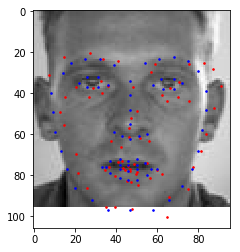

In [14]:
item = train_dataset[666]
landmarks = item['landmarks'].reshape(-1, 2)
T = torch.from_numpy(item['image'])
T = T.view(T.size(0), 1, 96, 96).expand(T.size(0), 3, 96, 96)
T = Variable(T.float())
T = alex(T).data.view(T.size(0), -1)
T = Variable(T)
y_pred = model(T).data.cpu().numpy().reshape(-1, 2)
    
show_landmarks_alex(item['image'].reshape(96, 96), y_pred, landmarks)

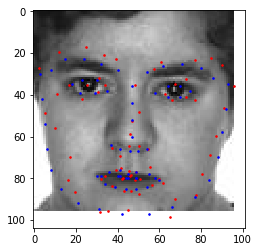

In [15]:
item = train_dataset[320]
landmarks = item['landmarks'].reshape(-1, 2)
T = torch.from_numpy(item['image'])
T = T.view(T.size(0), 1, 96, 96).expand(T.size(0), 3, 96, 96)
T = Variable(T.float())
T = alex(T).data.view(T.size(0), -1)
T = Variable(T)
y_pred = model(T).data.cpu().numpy().reshape(-1, 2)
    
show_landmarks_alex(item['image'].reshape(96, 96), y_pred, landmarks)

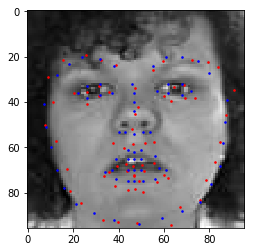

In [16]:
item = train_dataset[100]
landmarks = item['landmarks'].reshape(-1, 2)
T = torch.from_numpy(item['image'])
T = T.view(T.size(0), 1, 96, 96).expand(T.size(0), 3, 96, 96)
T = Variable(T.float())
T = alex(T).data.view(T.size(0), -1)
T = Variable(T)
y_pred = model(T).data.cpu().numpy().reshape(-1, 2)
    
show_landmarks_alex(item['image'].reshape(96, 96), y_pred, landmarks)

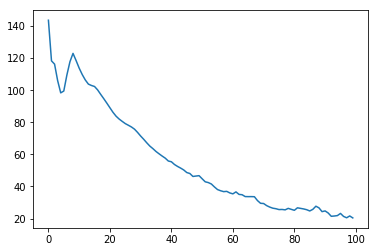

In [17]:
plt.plot(flag_final_test)

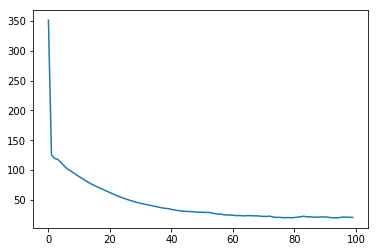

In [18]:
plt.plot(flag_final_train)